# 1. 解析cifar-10数据集
运行H_ResNeXt/src/01_parse_cifar10_to_png.py，将cifar-10数据集解析为png格式   

数据存放位置：   
F:\cv_paper\lesson\Data\cifar-10\cifar-10-python.tar   
解压得到：  
F:\cv_paper\lesson\Data\cifar-10\cifar-10-batches-py

经过01_parse_cifar10_to_png.py，得到：  
F:\cv_paper\lesson\Data\cifar-10\cifar10_train   
F:\cv_paper\lesson\Data\cifar-10\cifar10_test  


### 数据展示
<img src="imgs/cifar10.png" width="700" heith="700" />

In [1]:
import os
# -*- coding: utf-8 -*-
import os
BASE_DIR = os.path.dirname(os.getcwd())
os.environ['NLS_LANG'] = 'SIMPLIFIED CHINESE_CHINA.UTF8'
import sys
sys.path.append(BASE_DIR)
from PIL import Image
from torch.utils.data import Dataset
import os
from datetime import datetime
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.nn.init as init
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from tools.cifar10_dataset import CifarDataset
from tools.common_tools import ModelTrainer, show_confMat, plot_line

class CifarDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        assert (os.path.exists(data_dir)), "data_dir:{} 不存在！".format(data_dir)

        self.data_dir = data_dir
        self._get_img_info()
        self.transform = transform

    def __getitem__(self, index):
        fn, label = self.img_info[index]
        img = Image.open(fn).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        if len(self.img_info) == 0:
            raise Exception("未获取任何图片路径，请检查dataset及文件路径！")
        return len(self.img_info)

    def _get_img_info(self):
        sub_dir_ = [name for name in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, name))]
        sub_dir = [os.path.join(self.data_dir, c) for c in sub_dir_]

        self.img_info = []
        for c_dir in sub_dir:
            path_img = [(os.path.join(c_dir, i), int(os.path.basename(c_dir))) for i in os.listdir(c_dir) if
                        i.endswith("png")]
            self.img_info.extend(path_img)
            
            
def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train):
        img_ = np.array(img_) * 255

    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]) )

    return img_

50000
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 5.8039e-01, 5.7647e-01,  ..., 5.8824e-01,
          5.8039e-01, 5.7647e-01],
         [0.0000e+00, 5.8431e-01, 5.8039e-01,  ..., 5.8824e-01,
          5.8431e-01, 5.7647e-01],
         [0.0000e+00, 5.8824e-01, 5.8431e-01,  ..., 5.8824e-01,
          5.8431e-01, 5.8039e-01]],

        [[2.9802e-08, 2.9802e-08, 2.9802e-08,  ..., 2.9802e-08,
          2.9802e-08, 2.9802e-08],
         [2.9802e-08, 2.9802e-08, 2.9802e-08,  ..., 2.9802e-08,
          2.9802e-08, 2.9802e-08],
         [2.9802e-08, 2.9802e-08, 2.9802e-08,  ..., 2.9802e-08,
          2.9802e-08, 2.9802e-08],
         ...,
         [2.9802e-08, 6.3137e-01, 6.2745e-01,  ..., 6.3529e-01,
         

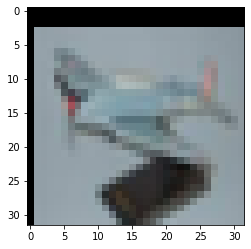

In [2]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

valid_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

# 构建MyDataset实例
train_dir = os.path.join(BASE_DIR, "..", "Data", "cifar-10",  "cifar10_train")
train_data = CifarDataset(data_dir=train_dir, transform=train_transform)

print(train_data.__len__()) 

img_tensor, label = train_data.__getitem__(66)

img_rgb = transform_invert(img_tensor, train_transform)
print(img_tensor, label)
print(img_rgb)
plt.imshow(img_rgb)

# 2. 针对cifar-10的DenseNet结构
参考：https://github.com/bamos/densenet.pytorch/blob/master/densenet.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


# dense layer
class Bottleneck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(Bottleneck, self).__init__()
        interChannels = 4 * growthRate
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)  # 在此体现dense connection，两个特征图拼接起来
        return out

#  BN----ReLU----Conv
#  若不采用Bottleneck， 则采用SingleLayer， SingleLayer 与 Bottleneck 是对等的概念
class SingleLayer(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, growthRate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = torch.cat((x, out), 1)
        return out


class Transition(nn.Module):
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))  # BN----ReLU----Conv
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, growthRate, depth, reduction, nClasses, bottleneck):
        super(DenseNet, self).__init__()

        nDenseBlocks = (depth-4) // 3   # 4 表示第一个卷积层 + 2个transition + 1个FC层输出分类 ；；；3表示3个block
        if bottleneck:
            nDenseBlocks //= 2  # 2表示一个基础操作模块中有2层

        nChannels = 2*growthRate    # 第一个卷积的卷积核个数为 growthRate的两倍
        self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1, bias=False)

        # 第一个 denseblock
        self.dense1 = self._make_denseblock(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate                 # 计算经过denseblock之后有多少个通道
        nOutChannels = int(math.floor(nChannels*reduction))  # 计算经过Compression后，还有几个通道reduction对应论文中的θ
        self.trans1 = Transition(nChannels, nOutChannels)

        # 第二个 denseblock
        nChannels = nOutChannels
        self.dense2 = self._make_denseblock(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans2 = Transition(nChannels, nOutChannels)

        # 第三个 denseblock
        nChannels = nOutChannels
        self.dense3 = self._make_denseblock(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate

        # 分类输出层
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.fc = nn.Linear(nChannels, nClasses)

        # 权值初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_denseblock(self, nChannels, growthRate, nDenseBlocks, bottleneck):
        """
        创建denseblock
        :param nChannels: 进入block的特征图的通道数
        :param growthRate: int
        :param nDenseBlocks: blocks堆叠的数量
        :param bottleneck: boolean，是否需要bottleneck， densenet-b
        :return:
        """
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(Bottleneck(nChannels, growthRate))
            else:
                layers.append(SingleLayer(nChannels, growthRate))
            nChannels += growthRate     # 通道数逐渐增加，从此看出block中各层的输入均包含进入block的特征图
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = torch.squeeze(F.avg_pool2d(F.relu(self.bn1(out)), 8))
        out = self.fc(out)
        return out

In [4]:

densenet_model = DenseNet(growthRate=12, depth=40, reduction=0.5, bottleneck=True, nClasses=10)
print(densenet_model)

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

# 3. 模型训练器  ModelTrainer

定义模型训练类，用于完成模型前向，反向传播，并记录训练loss，accuracy等指标  

目的是简化主代码

In [5]:
class ModelTrainer(object):


    @staticmethod
    def train(data_loader, model, loss_f, optimizer, epoch_id, device, max_epoch):
        model.train()

        conf_mat = np.zeros((10, 10))   # 混淆矩阵，用于绘图，且计算accuracy，precision，recall等指标很方便
        loss_sigma = []

        for i, data in enumerate(data_loader):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            optimizer.zero_grad()
            loss = loss_f(outputs, labels)
            loss.backward()
            optimizer.step()

            # 统计预测信息
            _, predicted = torch.max(outputs.data, 1)

            # 统计混淆矩阵
            for j in range(len(labels)):
                cate_i = labels[j].cpu().numpy()
                pre_i = predicted[j].cpu().numpy()
                conf_mat[cate_i, pre_i] += 1.

            # 统计loss
            loss_sigma.append(loss.item())                  # 记录每个iterations的loss，待会取均值就得到epochs的loss
            acc_avg = conf_mat.trace() / conf_mat.sum()     # 利用混淆矩阵求取accuracy， 矩阵的迹 除以 总元素 

            # 每10个iteration 打印一次训练信息，loss为10个iteration的平均
            if i % 50 == 50 - 1:
                print("Training: Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                    epoch_id + 1, max_epoch, i + 1, len(data_loader), np.mean(loss_sigma), acc_avg))

        return np.mean(loss_sigma), acc_avg, conf_mat

    @staticmethod
    def valid(data_loader, model, loss_f, device):
        model.eval()

        conf_mat = np.zeros((10, 10))
        loss_sigma = []

        for i, data in enumerate(data_loader):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_f(outputs, labels)

            # 统计预测信息
            _, predicted = torch.max(outputs.data, 1)

            # 统计混淆矩阵
            for j in range(len(labels)):
                cate_i = labels[j].cpu().numpy()
                pre_i = predicted[j].cpu().numpy()
                conf_mat[cate_i, pre_i] += 1.

            # 统计loss
            loss_sigma.append(loss.item())

        acc_avg = conf_mat.trace() / conf_mat.sum()

        return np.mean(loss_sigma), acc_avg, conf_mat

# 4.混淆矩阵概念
混淆矩阵(Confusion Matrix)常用来观察分类结果，其是一个N\*N的方阵，N表示类别数。 

混淆矩阵的行表示真实类别，列表示预测类别。例如，猫狗的二分类问题，有猫的图像10张，狗的图像30张，模型对这40张图片进行预测，得到的混淆矩阵为

| 类别|  阿猫   | 阿狗  |
|----|  ----  | ----  |
|阿猫 | 7  | 3 |
|阿狗| 10  | 20 |


从第一行中可知道，10张猫的图像中，7张预测为猫，3张预测为狗，猫的召回率(Recall)为7/10 = 70%，   
从第二行中可知道，30张狗的图像中，8张预测为猫，22张预测为狗，狗的召回率为20/30 = 66.7%，  
从第一列中可知道，预测为猫的17张图像中，有7张是真正的猫，猫的精确度(Precision)为7 / 17 = 41.17%   
从第二列中可知道，预测为狗的23张图像中，有20张是真正的狗，狗的精确度(Precision)为20 / 23 = 86.96%  

模型的准确率(Accuracy)为  (7+20) / 40 = 67.5%   

可以发现通过混淆矩阵可以清晰的看出网络模型的分类情况，若再结合上颜色可视化，可方便的看出模型的分类偏好。  


<img src="imgs/Confusion_Matrixtrain.png">